# DGF-PTTOT

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from cosmo_dlp.model import CosmoData, CosmoPredictor
import pickle
import io
import yaml
import seaborn as sns
import numpy as np
import os.path
sns.set_theme(style="whitegrid")

train_df = pd.read_csv("data/input/DGF_PTTOT_train.csv")
test_df = pd.read_csv("data/input/DGF_PTTOT_test.csv")
all_df = pd.concat([train_df, test_df])

## Regressione lineare
Il primo modello da considerare è la regressione lineare.

In [2]:
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
data = CosmoData(train_df, None, test_df)
reg = reg.fit(data.train_set()[0], data.train_set()[1])

test_res_lr = test_df.copy()
test_res_lr["target"] = test_res_lr.time_tot
test_res_lr["prediction"] = np.exp(reg.predict(data.test_set()[0]))
test_res_lr["residual"] = test_res_lr.target - test_res_lr.prediction
test_res_lr["abs_err"] = (test_res_lr.target - test_res_lr.prediction).abs()
test_res_lr["rel_err"] = test_res_lr.abs_err / test_res_lr.target
test_res_lr[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,160073.000000,160073.000000
mean,383.692349,0.484273
std,561.114078,0.966801
min,0.001645,0.000004
25%,47.743464,0.157537
50%,204.642899,0.292757
75%,489.999073,0.451215
max,7861.461298,17.215585


In [3]:
print("RMSE:", np.sqrt((test_res_lr.abs_err ** 2).mean()))

RMSE: 679.755000467181


Il grafico del tempo previsto e del tempo osservato mostra come la regressione lineare sottostimi i tempi più lunghi e come tale errore aumenti all'aumentare del tempo osservato.

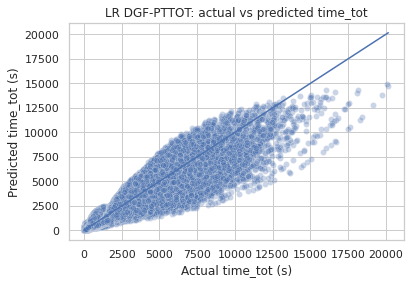

In [4]:
plt.title("LR DGF-PTTOT: actual vs predicted time_tot")
plt.plot([0, test_res_lr.target.max()], [0, test_res_lr.target.max()])
sns.scatterplot(data=test_res_lr, x="target", y="prediction", alpha=0.3)
plt.xlabel("Actual time_tot (s)")
plt.ylabel("Predicted time_tot (s)")
plt.savefig("tex/images/dgf-pttot/lr-correlazione-osservazione-previsione.pdf")
plt.show()

Possiamo notare la medesima cosa analizzando il grafico dei residui. Inoltre possiamo notare come si presente un pattern che suggerisce non linearità.

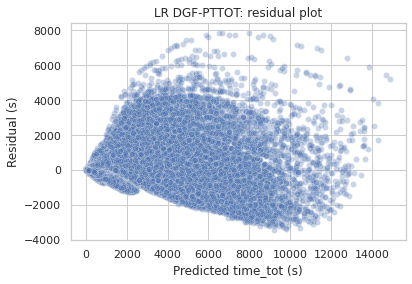

In [5]:
plt.title("LR DGF-PTTOT: residual plot")
sns.scatterplot(data=test_res_lr, x="prediction", y="residual", alpha=0.3)
plt.xlabel("Predicted time_tot (s)")
plt.ylabel("Residual (s)")
plt.savefig("tex/images/dgf-pttot/lr-grafico-residui.pdf")
plt.show()

Si può invece notare come la distribuzione dell'errore assoluto non sia unimodale.

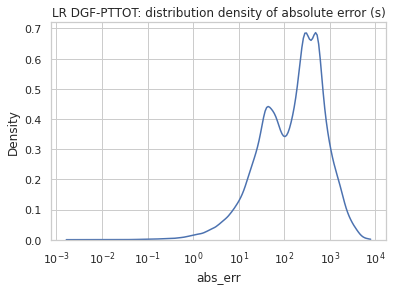

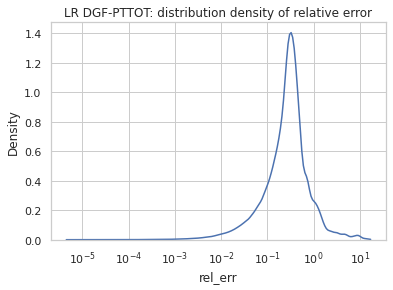

In [6]:
sns.kdeplot(data=test_res_lr, x="abs_err", log_scale=True, cumulative=False, cut=0, label="LR")
plt.xscale("log")
plt.title("LR DGF-PTTOT: distribution density of absolute error (s)")
plt.show()

sns.kdeplot(data=test_res_lr, x="rel_err", log_scale=True, cumulative=False, cut=0, label="LR")
plt.title("LR DGF-PTTOT: distribution density of relative error")
plt.show()

## DGF-PT2 con HP tuning
Il modello è stato sottoposto a hyperparameter tuning, effettuando 100 tentativi con Bayesian Optimization. Come funzione obiettivo da minimizzare è stato considerato unicamente RMSE, in quanto si è interessati a minimizzare l'errore per le esecuzioni più lunghe e a non avere outlier. Per ogni tentativo, è stato effettuato il 10-fold cross validation ed è stato preso il minimo valore di RMSE del cross-validation set.

In [7]:
with open("data/hpopt/DGF_PTTOT.pk", "rb") as fp:
    trials = pickle.load(fp)
    best = trials.best_trial

In [8]:
cv_res = pd.read_csv(io.StringIO(best["result"]["csv"]))
config = best["result"]["config"]

In [9]:
print("Best loss", best["result"]["loss"])

Best loss 118.7745537215804


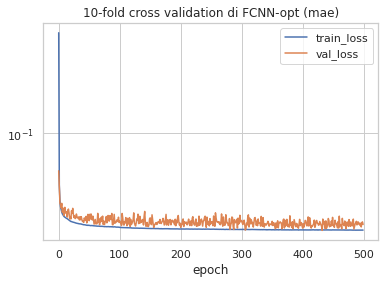

In [10]:
cv_res.groupby("epoch")[["train_loss", "val_loss"]].mean().plot(grid=True, logy=True)
plt.title(f"10-fold cross validation di FCNN-opt ({config['loss']})")
plt.show()

Epoch del minimo della funzione obiettivo, sarà usata successivamente per riaddestrare il modello.

In [11]:
best_epoch = cv_res.groupby("epoch").val_loss.mean().idxmin()
print("Best epoch", best_epoch)

Best epoch 432


Il modello ottimizzato ha due hidden layer.

In [12]:
print(yaml.dump(config))

batch: 256
epochs: 500
kfold: 10
loss: mae
model:
  layers: !!python/tuple
  - dropout: 0.0
    size: 38
  - dropout: 0.0
    size: 31
optimizer:
  lr: 0.0010018009851965168
  name: adam
  weight_decay: 0.0918103596185136



Il modello viene riaddestrato usando tutto il training set, fino all'epoch che ha dato il miglior risultato durante l'HP tuning.

In [13]:
train_res_opt_file = "data/output/DGF_PTTOT_train_result.csv"
test_res_opt_file = "data/output/DGF_PTTOT_test_result.csv"
model_file = "data/model/DGF_PTTOT_model.pth"
if os.path.exists(train_res_opt_file) and os.path.exists(test_res_opt_file):
    print("Carico i risultati del modello da file")
else:
    data = CosmoData(train_df, None, test_df, config["batch"])
    model = CosmoPredictor(data.input_size, config)
    train_res_opt = model.fit(data, best_epoch)
    test_res_opt = model.test(data)
    model.save(model_file)
    train_res_opt.to_csv(train_res_opt_file, index=False)
    test_res_opt.to_csv(test_res_opt_file, index=False)
    
train_res_opt = pd.read_csv(train_res_opt_file)
test_res_opt = pd.read_csv(test_res_opt_file)

Carico i risultati del modello da file


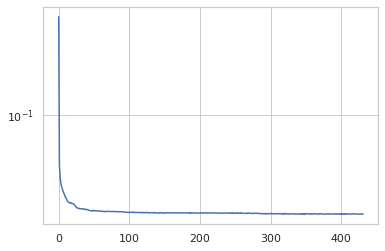

In [14]:
train_res_opt.train_loss.plot(grid=True, logy=True)
plt.show()

Si nota un sensibile miglioramento sia nell'errore assoluto che relativo rispetto a LR.

In [15]:
test_res_opt["abs_err"] = (test_res_opt.target - test_res_opt.prediction).abs()
test_res_opt["rel_err"] = test_res_opt.abs_err / test_res_opt.target
test_res_opt["residual"] = test_res_opt.target - test_res_opt.prediction
test_res_opt[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,160073.000000,1.600730e+05
mean,33.747999,2.875299e-02
std,121.375019,4.941044e-02
min,0.000076,4.512699e-07
25%,2.755844,7.981233e-03
50%,9.364975,1.740951e-02
75%,30.666260,3.247521e-02
max,6354.672852,7.881131e-01


Anche il RMSE è migliore rispetto a LR e si discosta di 7 secondi (6%) rispetto al RMSE del cross-validation set.

In [16]:
print("RMSE:", np.sqrt((test_res_opt.abs_err ** 2).mean()))

RMSE: 125.97908768537681


Possiamo notare il miglioramento, soprattutto nella previsione dei tempi più lunghi. Tuttavia, alcune previsioni divergono visibilmente, ma sono probabilmente dovute a esecuzioni anomale (si veda più avanti).

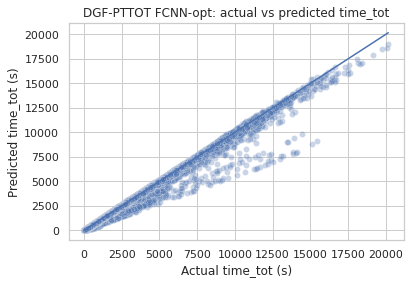

In [17]:
plt.title("DGF-PTTOT FCNN-opt: actual vs predicted time_tot")
plt.plot([test_res_opt.target.min(), test_res_opt.target.max()], [test_res_opt.target.min(), test_res_opt.target.max()])
sns.scatterplot(x=test_res_opt.target, y=test_res_opt.prediction, alpha=0.3)
plt.xlabel("Actual time_tot (s)")
plt.ylabel("Predicted time_tot (s)")
plt.savefig("tex/images/dgf-pttot/fcnn-opt-correlazione-osservazione-previsione.pdf")
plt.show()

Ad esclusione delle previsioni divergenti, possiamo notare una eteroschedasticità limitata.

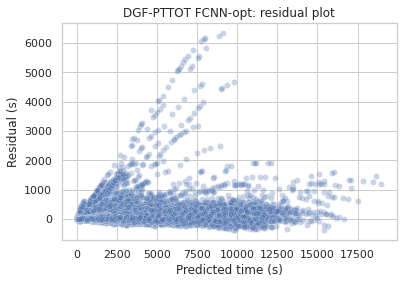

In [18]:
plt.title("DGF-PTTOT FCNN-opt: residual plot")
sns.scatterplot(data=test_res_opt, x="prediction", y="residual", alpha=0.3)
plt.xlabel("Predicted time (s)")
plt.ylabel("Residual (s)")
plt.savefig("tex/images/dgf-pttot/fcnn-opt-grafico-residui.pdf")
plt.show()

## Confronto tra modelli

Qui sotto, sono confrontati i grafici di correlazione tra errore assoluto e tempo osservato dei due modelli. Si può notare come l'FCNN ottimizzato abbia un comportamento sensibilmente migliore rispetto a LR. Nei grafici di FCNN rimangono alcuni errori eccessivi di previsione, ma in realtà è corretto, in quanto sono riferiti a esecuzioni anomale (si veda più avanti per una analisi).

In [19]:
for name, df in zip(("LR", "FCNN opt"), (test_res_lr, test_res_opt)):
    print(f"MAE {name}:", df.abs_err.mean())

MAE LR: 383.6923490295602
MAE FCNN opt: 33.74799880056103


In [20]:
for name, df in zip(("LR", "FCNN opt"), (test_res_lr, test_res_opt)):
    print(f"RMSE {name}:", np.sqrt((df.abs_err ** 2).mean()))

RMSE LR: 679.755000467181
RMSE FCNN opt: 125.97908768537681


In [21]:
for name, df in zip(("LR", "FCNN opt"), (test_res_lr, test_res_opt)):
    print(f"MAPE {name}:", 100 * df.rel_err.mean())

MAPE LR: 48.42733809766763
MAPE FCNN opt: 2.8752986290800604


La correlazione tra tempo di esecuzione e errore assoluto di FCNN presenta pattern lineari solo nel caso delle esecuzioni anomale.

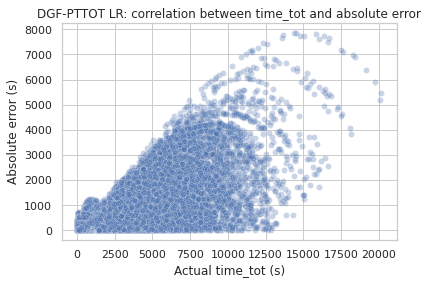

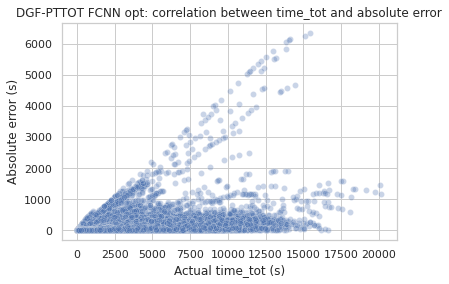

In [22]:
for name, df in zip(("LR", "FCNN opt"), (test_res_lr, test_res_opt)):
    sns.scatterplot(data=df, x="target", y="abs_err", alpha=0.3)
    plt.title(f"DGF-PTTOT {name}: correlation between time_tot and absolute error")
    plt.xlabel("Actual time_tot (s)")
    plt.ylabel("Absolute error (s)")
    plt.show()

Qui sotto vediamo la correlazione con l'errore relativo: anche qui, abbiamo dei pattern, ma sono probabilmente dovuti ad anomalie.

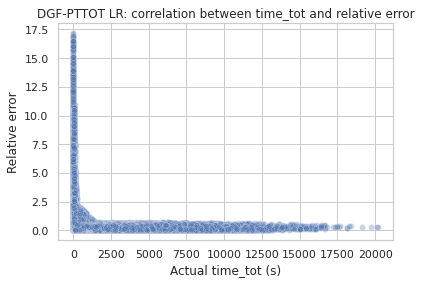

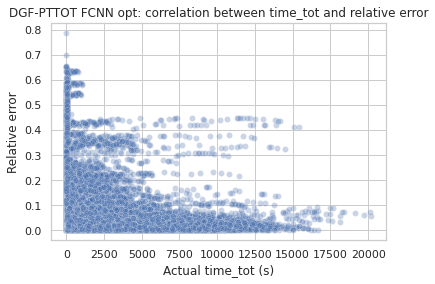

In [23]:
for name, df in zip(("LR", "FCNN opt"), (test_res_lr, test_res_opt)):
    sns.scatterplot(data=df, x="target", y="rel_err", alpha=0.3)
    plt.title(f"DGF-PTTOT {name}: correlation between time_tot and relative error")
    plt.xlabel("Actual time_tot (s)")
    plt.ylabel("Relative error")
    plt.show()

Di seguito, possiamo vedere le funzioni cumulative dell'errore assoluto e relativo dei due modelli studiati. Come si poteva già dedurre dalle precedenti osservazioni, FCNN è sensibilmente migliore.

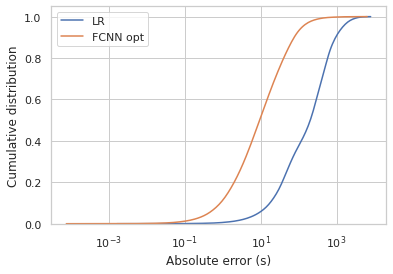

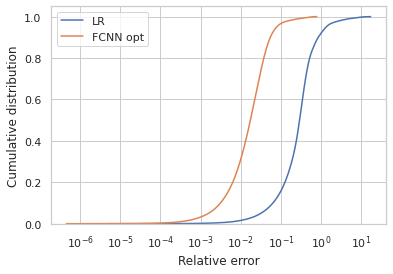

In [24]:
for name, df in zip(("LR", "FCNN opt"), (test_res_lr, test_res_opt)):
    sns.kdeplot(data=df, x="abs_err", log_scale=True, cumulative=True, cut=0, label=name)
    
plt.legend()
plt.xlabel("Absolute error (s)")
plt.ylabel("Cumulative distribution")
plt.savefig("tex/images/dgf-pttot/cdf-errore-assoluto.pdf")
plt.show()

for name, df in zip(("LR", "FCNN opt"), (test_res_lr, test_res_opt)):
    sns.kdeplot(data=df, x="rel_err", log_scale=True, cumulative=True, cut=0, label=name)
    
plt.legend()
plt.xlabel("Relative error")
plt.ylabel("Cumulative distribution")
plt.savefig("tex/images/dgf-pttot/cdf-errore-relativo.pdf")
plt.show()

Nel caso della funzione di distribuzione dell'errore assoluto notiamo come LR non sia unimodale.

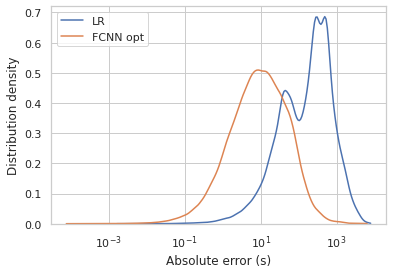

In [ ]:
for name, df in zip(("LR", "FCNN opt"), (test_res_lr, test_res_opt)):
    sns.kdeplot(data=df, x="abs_err", log_scale=True, cumulative=False, cut=0, label=name)
    
plt.legend()
plt.xlabel("Absolute error (s)")
plt.ylabel("Distribution density")
plt.savefig("tex/images/dgf-pttot/pdf-errore-assoluto.pdf")
plt.show()

for name, df in zip(("LR", "FCNN opt"), (test_res_lr, test_res_opt)):
    sns.kdeplot(data=df, x="rel_err", log_scale=True, cumulative=False, cut=0, label=name)
    
plt.legend()
plt.xlabel("Relative error")
plt.ylabel("Distribution density")
plt.savefig("tex/images/dgf-pttot/pdf-errore-relativo.pdf")
plt.show()

Qui sotto, si riportano i grafici dei che mostrano la correlazione tra osservato e previsto, in modo da poterli confrontare più facilmente.

In [ ]:
for name, df in zip(("LR", "FCNN opt"), (test_res_lr, test_res_opt)):
    plt.title(name)
    sns.scatterplot(x=df.target, y=df.prediction, alpha=0.3)
    plt.plot([df.target.min(), df.target.max()], [df.target.min(), df.target.max()])
    plt.xlabel("Actual time_tot (s)")
    plt.ylabel("Predicted time_tot (s)")
    plt.show()

Nei grafici di correlazione tra tempo osservato e previsto, tra tempo osservato e errore assoluto, tra tempo osservato e relativo e tra tempo previsto e residuo, si possono notare alcuni pattern evidenti che divergono dal comportamento delle restanti previsioni. L'ipotesi è che siano delle esecuzioni anomale che il nostro modello non riesce a prevedere.

In [ ]:
df = pd.concat([test_df, test_res_opt], axis=1)

Analizzando il dataset, notiamo alcune esecuzioni evidentemente anomale. Prendiamo il dataset originale e analizziamo questi record, andandoli a confrontare con esecuzioni simili (quindi, senza considerare il subdomain_ratio e con un numero simile di core per nodo). Possiamo vedere qui sotto come siano effettivamente anomale, segnale di qualche malfunzionamento durante l'esecuzione di questi modelli.

In [ ]:
df_orig = pd.concat([pd.read_csv("data/input/DGF_PT2_train.csv"), pd.read_csv("data/input/DGF_PT2_test.csv")])

In [ ]:
df_orig.query("grid_step==20 and n_nodes == 16 and n_cores >= 32 and single_precision == 0").sort_values("time2")

In [ ]:
df_orig.query("grid_step==20 and n_nodes == 14 and n_cores >= 30 and n_cores <= 34 and single_precision == 0").sort_values("time2")

In [ ]:
df_orig.query("grid_step==20 and n_nodes == 16 and n_cores == 18 and single_precision == 0").sort_values("time2")

In [ ]:
df_orig.query("grid_step==20 and n_nodes == 18 and n_cores == 22 and single_precision == 0").sort_values("time2")

In [ ]:
df_orig.query("grid_step==20 and n_nodes == 10 and n_cores == 24 and single_precision == 1").sort_values("time2")

In [ ]:
df_orig.query("grid_step==20 and n_nodes == 10 and n_cores == 18 and single_precision == 1").sort_values("time2")

In [ ]:
df_orig.query("grid_step==20 and n_nodes == 14 and n_cores == 26 and single_precision == 1").sort_values("time2")

In [ ]:
import numpy as np
anomalies = (
    (20, 16, 34, 0, 2.214286),
    (20, 14, 32, 0, 1.823529),
    (20, 16, 18, 0, 1.148148),
    (20, 18, 22, 0, 5),
    (20, 10, 24, 1, 1.64),
    (20, 10, 18, 1, 1.242424),
    (20, 46, 26, 0, 1.9),
    (20, 14, 26, 1, 2.235294),
)
df_clean = df.copy()
for grid_step, n_nodes, n_cores, single_precision, subdomain_ratio in anomalies: 
    df_clean = df_clean.drop(df[
        (df.grid_step==grid_step)&
        (df.n_nodes==n_nodes)&
        (df.n_cores==n_cores)&
        (df.single_precision==single_precision)&
        np.isclose(df.subdomain_ratio, subdomain_ratio)
    ].index)

df_anom = pd.concat([
    df[
        (df.grid_step==grid_step)&
        (df.n_nodes==n_nodes)&
        (df.n_cores==n_cores)&
        (df.single_precision==single_precision)&
        np.isclose(df.subdomain_ratio, subdomain_ratio)
    ] for grid_step, n_nodes, n_cores, single_precision, subdomain_ratio in anomalies
])

Di seguito, sono nuvoamente riportati i grafici ma con le anomalie evidenziate. Possiamo notare come siano presenti ancora alcuni pattern che evidenziano potenziali esecuzioni anomale.

In [ ]:
sns.scatterplot(
    data=df_clean,
    x="target",
    y="prediction", 
    alpha=0.3,
    color="b",
    label="esecuzioni normali",
)
sns.scatterplot(
    data=df_anom,
    x="target",
    y="prediction", 
    alpha=0.3,
    color="r",
    label="esecuzioni anomale",
)
plt.plot([df.target.min(), df.target.max()], [df.target.min(), df.target.max()])
plt.title("DGF-PTTOT FCNN-opt: actual vs predicted time_tot (s)")
plt.xlabel("Actual time_tot (s)")
plt.ylabel("Predicted time_tot (s)")
plt.savefig("tex/images/dgf-pttot/fcnn-opt-correlazione-osservazione-previsione.pdf")
plt.show()

In [ ]:
sns.scatterplot(
    data=df_clean,
    x="target",
    y="abs_err", 
    alpha=0.3,
    color="b",
    label="esecuzioni normali",
)
sns.scatterplot(
    data=df_anom,
    x="target",
    y="abs_err", 
    alpha=0.3,
    color="r",
    label="esecuzioni anomale",
)
plt.title("DGF-PTTOT FCNN-opt: correlation between actual time_tot and absolute error")
plt.xlabel("Actual time_tot (s)")
plt.ylabel("Absolute error (s)")
plt.show()

In [ ]:
sns.scatterplot(
    data=df_clean,
    x="target",
    y="rel_err", 
    alpha=0.3,
    color="b",
    label="esecuzioni normali",
)
sns.scatterplot(
    data=df_anom,
    x="target",
    y="rel_err", 
    alpha=0.3,
    color="r",
    label="esecuzioni anomale",
)
plt.title("DGF-PTTOT FCNN-opt: correlation between actual time_tot and relative error")
plt.xlabel("Actual time_tot (s)")
plt.ylabel("Relative error")
plt.show()

## Conclusioni

Il modello ha prestazioni soddisfacenti: in particolar modo, nel caso delle esecuzioni più lunghe, l'errore relativo è contenuto (< 10%). Inoltre, possiamo notare si possano riconoscere esecuzioni anomale dall'errore della previsione del modello.